# Part I [Total: 60 points] - Implementing Advantage Actor Critic (A2C) and Solving Simple Environment

In [5]:
import torch
from torch import nn
import gymnasium as gym
from itertools import count
from torch import multiprocessing as mp
import math
import random
import matplotlib.pyplot as plt

In [15]:
!python3 kishorku_assignment3_part1.py

Finished initializing of A3C agent
100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 190.91it/s]


In [16]:
cartpole_episode_losses = torch.load("A3C_cartpole_episode_losses.pkl")
cartpole_episode_steps = torch.load("A3C_cartpole_episode_steps.pkl")
cartpole_episode_rewards = torch.load("A3C_cartpole_episode_rewards.pkl")

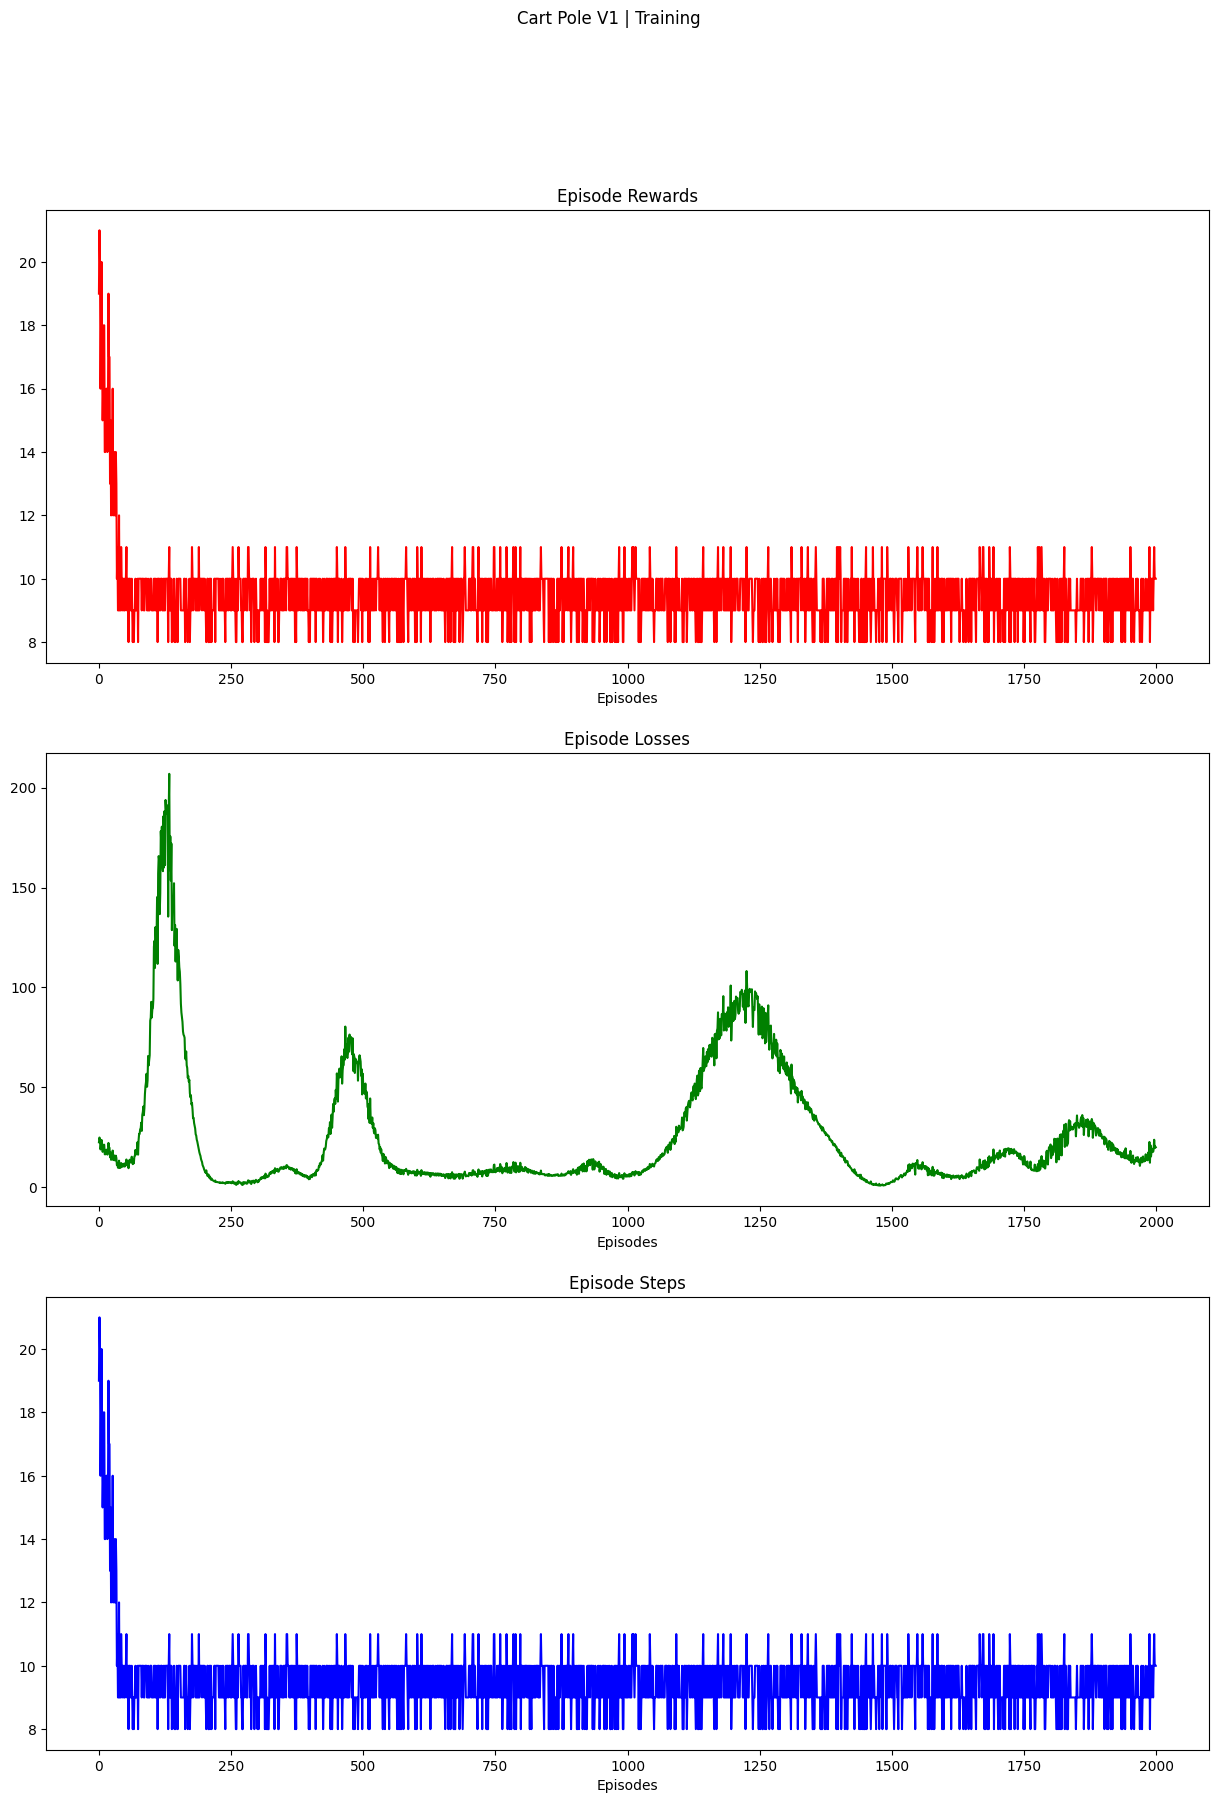

In [17]:
plt.figure(figsize=(15, 20))
plt.subplot(311),plt.plot(list(range(len(cartpole_episode_rewards))), cartpole_episode_rewards, c="r"),plt.xlabel("Episodes"), plt.title('Episode Rewards')
plt.subplot(312),plt.plot(list(range(len(cartpole_episode_losses))), cartpole_episode_losses, c="g"),plt.xlabel("Episodes"), plt.title('Episode Losses')
plt.subplot(313),plt.plot(list(range(len(cartpole_episode_steps))), cartpole_episode_steps, c="b"),plt.xlabel("Episodes"), plt.title('Episode Steps')
plt.suptitle("Cart Pole V1 | Training")
plt.show()

In [8]:
class ActorCritic(nn.Module):

    def __init__(self,
                 n_states,
                 n_actions):
        super().__init__()
        self.shared_fc = nn.Sequential(
            nn.Linear(n_states, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, n_actions),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Linear(64, 1)

    def forward(self, x):
        x = self.shared_fc(x)
        return self.actor(x), self.critic(x)